To prepare our CIFAR10 dataset for training, we apply data augmentation techniques and transforms. Specifically, we use the following techniques:

Random Crop: This technique creates a random subset of an original image. We use this to randomly crop 32x32-pixel patches from the original images, which helps our model learn to recognize objects that might appear anywhere in the image.

Random Horizontal Flip: This technique flips an image horizontally with a probability p. We use this to further augment our dataset and make our model more robust to variations in the orientation of objects.

To Tensor: We use the To Tensor transform to convert our images to PyTorch tensors and scale the pixel values by 255.

Normalize: We apply the Normalize transform to the tensor images so that their values have a mean of 0.0 and a standard deviation of 1.0. This helps our model learn from the input data more effectively.

We download the CIFAR10 dataset to the root directory ./data. To ensure that we get the same validation set each time we run the code, we set PyTorch's random number generator to a seed value of 17. We also import the datasets and convert the images into PyTorch tensors.


In [ ]:
import multiprocessing
import torchvision
import torchvision.transforms as transforms
import numpy as np
from torch.utils.data import DataLoader
import torch
torch.manual_seed(17)

from torchsummary import summary
from tqdm import tqdm
import matplotlib.pyplot as plt

class FetchDataset:

    def __init__(self, dataset="CIFAR10", batch_size=64):
        print("Initializing fetching %s dataset using torchvision"%(dataset))
        # check if the dataset exists in torchvision
        self.datasetObject = torchvision.datasets.__dict__.get(dataset, None)
        if self.datasetObject == None:
            raise Exception("Dataset %s might not be in torchvision."%(dataset))
        self.batch_size = batch_size
        self.transformers_training = []
        self.transformers_testing = []
        # set number of workers available for multiprocessing
        self.workersAvailable = min(multiprocessing.cpu_count(), 14)
      
    def dataAugmentation(self, size=32, padding=3):
        # add data augmentation transforms to the training set
        self.transformers_training.append(transforms.RandomHorizontalFlip())
        self.transformers_training.append(transforms.RandomCrop(size=size, padding=padding))
        self.transformers_training.append(transforms.functional.equalize)
        self.transformers_testing.append(transforms.functional.equalize)

    def __addToTensor(self):
        # add ToTensor transform to the training and testing sets
        self.transformers_training.append(transforms.ToTensor())
        self.transformers_testing.append(transforms.ToTensor())

    def addNormalizer(self):
        self.__addToTensor()
        # load training set to compute mean and standard deviation
        dataset_training = self.datasetObject(root="./data", train=True, download=True)
        data_train = dataset_training.data/255.0
        mean = data_train.mean(axis=(0, 1, 2))
        std = data_train.std(axis=(0, 1, 2))
        # add Normalize transform to the training and testing sets
        self.transformers_training.append(transforms.Normalize(mean=mean, std=std))
        self.transformers_testing.append(transforms.Normalize(mean=mean, std=std))
        

    def getLoaders(self):
        if len(self.transformers_training) == 0:
            self.__addToTensor()
        # create data loaders with the defined batch size, transformers and number of workers
        dataset_training = self.datasetObject(root="./data", train=True, download=True, transform=transforms.Compose(self.transformers_training))
        dataset_testing = self.datasetObject(root="./data", train=False, download=True, transform=transforms.Compose(self.transformers_testing))
        load_train = DataLoader(dataset_training, batch_size=self.batch_size, shuffle=True, num_workers=self.workersAvailable)
        load_test = DataLoader(dataset_testing, batch_size=self.batch_size, shuffle=False, num_workers=self.workersAvailable)
        # return the training and testing data loaders
        return load_train, load_test
    
# create a new instance of FetchDataset for the CIFAR10 dataset with batch size of 128
df = FetchDataset(dataset="CIFAR10", batch_size=128)
# add data augmentation transforms to the training set with size 32 and padding 4
df.dataAugmentation(size=32, padding=4)
# add normalizing transforms to the training and testing sets
df.addNormalizer()
# get the training and testing data loaders
trainLoader, testLoader = df.getLoaders()


Initializing fetching CIFAR10 dataset using torchvision


100%|██████████| 170498071/170498071 [00:21<00:00, 8043368.25it/s] 


Extracting ./data/cifar-10-python.tar.gz to ./data
Files already downloaded and verified
Files already downloaded and verified


Modified the basic resnet model from https://github.com/kuangliu/pytorch-cifar/blob/master/models/resnet.py 

• Ci, the number of channels in the ith layer.
• Fi, the filter size in the ith layer
• Ki, the kernel size in the ith skip connection
• P, the pool size in the average pool laye

Using the following values for the Hyperparameters (design variables) in our architectures : 

    C=[64,128,128,256]
    F=[3,3,3,3]
    K=[1,1,1,1]  
    P=4



In [ ]:
# Import necessary PyTorch modules
import torch.nn as nn
import torch.nn.functional as F

# Define the BasicBlock class, which is used to construct the layers in the ResNet architecture
class BasicBlock(nn.Module):

    # Initialize the BasicBlock class
    def __init__(self, in_planes, planes, kernel_size, skip_kernel, stride=1):
        super(BasicBlock, self).__init__()

        # Define the first convolutional layer
        self.conv1 = nn.Conv2d(in_planes, planes, kernel_size=kernel_size, stride=stride, padding=1, bias=False)
        self.bn1 = nn.BatchNorm2d(planes)

        # Define the second convolutional layer
        self.conv2 = nn.Conv2d(planes, planes, kernel_size=kernel_size, stride=1, padding=1, bias=False)
        self.bn2 = nn.BatchNorm2d(planes)

        # Define the shortcut connection, which is used to add the output of the convolutional layers to the input
        self.shortcut = nn.Sequential()

        # If the stride is not 1 or the number of input planes is not equal to the number of output planes, 
        # define a convolutional layer and a batch normalization layer for the shortcut connection
        if stride != 1 or in_planes != planes:
            self.shortcut = nn.Sequential(
                nn.Conv2d(in_planes, planes, kernel_size=skip_kernel, stride=stride, bias=False),
                nn.BatchNorm2d(planes)
            )

    # Define the forward pass for the BasicBlock class
    def forward(self, x):
        # Apply the first convolutional layer, batch normalization, and ReLU activation
        out = F.relu(self.bn1(self.conv1(x)))

        # Apply the second convolutional layer and batch normalization
        out = self.bn2(self.conv2(out))

        # Add the shortcut connection to the output of the convolutional layers
        out += self.shortcut(x)

        # Apply the ReLU activation
        out = F.relu(out)

        return out

# Define the ResNet class, which is used to construct the ResNet architecture
class ResNet(nn.Module):

      # Initialize the ResNet class
      def __init__(self,N:int, B:list, C:list, F:list, K:list, P:int, num_classes=10):
          super(ResNet, self).__init__()

          # Initialize the number of input planes
          self.in_planes = C[0]

          # Set the block to the BasicBlock class
          self.block = BasicBlock

          # Store the values of N, B, C, F, K, and P
          self.N, self.B, self.C, self.F, self.K, self.P= N, B, C, F, K, P

          # Initialize a container for the layers
          self.layers = []

          # Set the stride for each layer
          self.S = [2] * N
          self.S[0] = 1

          # Calculate the input dimension for the output linear layer
          self.outLayerInSize = C[N-1]*(32//(P*2**(N-1)))*(32//(P*2**(N-1)))


          # Print Model Config
          print("\n\nModel Config: "
              "\n-------------------------------------"
              "\nN (# Layers)\t:",self.N,
              "\nB (# Blocks)\t:",self.B,
              "\nC (# Channels)\t:",C,
              "\nF (Conv Kernel)\t:",F,
              "\nK (Skip Kernel)\t:",K,
              "\nP (Pool Kernel)\t:",P,)

          # Define the first convolution layer with 3 input channels, C[0] output channels, F[0] kernel size,
          # stride of 1, padding of 1, and no bias

          self.conv1 = nn.Conv2d(3, C[0], kernel_size=F[0], stride=1, padding=1, bias=False)
          # Define a batch normalization layer with C[0] channels

          self.bn1 = nn.BatchNorm2d(C[0])
                  # Define N residual blocks

          for i in range(N): 
              # Dynamically create variable names for each residual block using the exec() function

              exec("self.layer{} = self._make_layer(self.block, self.C[{}], self.B[{}], self.F[{}], self.K[{}], self.S[{}])"\
                  .format(i+1,i,i,i,i,i))
              # Append the residual block to the layers ModuleList
              exec("self.layers.append(self.layer{})".format(i+1))
                    # Define the final linear layer with input size of outLayerInSize and output size of num_classes
    
          self.linear = nn.Linear(self.outLayerInSize, num_classes)
          

      def _make_layer(self, block, planes, num_blocks, kernel_size, skip_kernel, stride):
          # Set stride for each block in the layer
          strides = [stride] + [1]*(num_blocks-1)
          layers = []
          for stride in strides:
              # Append each block to the layer with given arguments
              layers.append(block(self.in_planes, planes, kernel_size, skip_kernel, stride))
              # Update the number of input planes for the next block
              self.in_planes = planes
          # Return a sequential module containing all the blocks in the layer
          return nn.Sequential(*layers)


      def forward(self, x):
          # Apply the first convolutional layer followed by batch normalization and ReLU activation
          out = F.relu(self.bn1(self.conv1(x)))
          # Apply all the blocks in the layer
          for layer in self.layers:
              out = layer(out)
          # Apply average pooling with kernel size self.P
          out = F.avg_pool2d(out, self.P)
          # Flatten the output tensor
          out = out.view(out.size(0), -1)
          # Apply the fully connected linear layer
          out = self.linear(out)
          # Return the final output
          return out

def resnet_model():
        # Define the parameters for the ResNet architecture
        B=[3,3,2,3]  # number of blocks in each layer
        C=[64,128,128,256]  # number of output channels in each layer
        F=[3,3,3,3]  # kernel size for each layer
        K=[1,1,1,1]  # skip kernel size for each layer
        P=4  # average pooling kernel size
        N=len(B)  # number of layers in the network
        # Return a new ResNet model with the defined parameters
        return ResNet(N, B, C, F, K, P)


Checking Device - If GPU is available, GPU will be used.

In [ ]:
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
print(device)

cuda


In [ ]:
model = resnet_model()
model = model.to(device)



Model Config: 
-------------------------------------
N (# Layers)	: 4 
B (# Blocks)	: [3, 3, 2, 3] 
C (# Channels)	: [64, 128, 128, 256] 
F (Conv Kernel)	: [3, 3, 3, 3] 
K (Skip Kernel)	: [1, 1, 1, 1] 
P (Pool Kernel)	: 4


We run our model for 300 epochs, to find out the best possible accuracy. The accuracy becomes near about constant after it. We define our:

learning rate, weightDecay, type of optimizer to be used (we tried with Adam, Adagrad, AdaDelta), with Adadelta giving out the best accuracy.

The scheduler set the learning rate of each parameter group using a cosine annealing schedule


In [ ]:
EPOCHS=300
globalBestAccuracy = 0.0  # initialize the global best accuracy to 0.0
train_loss = []  # list to store train loss
test_loss = []  # list to store test loss
train_accuracy = []  # list to store train accuracy
test_accuracy = []  # list to store test accuracy

# define the loss function as Cross Entropy Loss with sum reduction
loss_function = torch.nn.CrossEntropyLoss(reduction='sum')

learningRate = 0.1  # set the learning rate to 0.1
weightDecay = 0.0001  # set the weight decay to 0.0001

# define the optimizer as Adadelta with the above defined learning rate and weight decay
optimizer = torch.optim.Adadelta(model.parameters(), lr=learningRate, weight_decay=weightDecay)

# define the learning rate scheduler as Cosine Annealing LR with the above defined optimizer, number of epochs, and minimum learning rate
scheduler = torch.optim.lr_scheduler.CosineAnnealingLR(optimizer, EPOCHS, eta_min=learningRate/10.0)

# print the model's evaluation mode
print(model.eval())

# calculate and print the total trainable parameters of the model
trainable_parameters = sum(p.numel() for p in model.parameters() if p.requires_grad)
print("Total Trainable Parameters : %s"%(trainable_parameters))

# if the total number of trainable parameters exceeds 5 million, raise an exception
if trainable_parameters > 5*(10**6):
    raise Exception("The total number of parameters exceeds 5 million")


ResNet(
  (conv1): Conv2d(3, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
  (bn1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
  (layer1): Sequential(
    (0): BasicBlock(
      (conv1): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
      (bn1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
      (conv2): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
      (bn2): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
      (shortcut): Sequential()
    )
    (1): BasicBlock(
      (conv1): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
      (bn1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
      (conv2): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
      (bn2): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=

Model Training and Testing.
Here we are training our model over 300 epochs and trying to find out the best accuracy our model provides for the CIFAR dataset.

In [ ]:
# Define the function to train the model and return the updated model and optimizer
def train(model, loader, optimizer):
    # Set the model to train mode
    model.train()
    # Clear the gradients of the optimizer
    optimizer.zero_grad()
    # Return the updated model and optimizer
    return model, optimizer

# Define the function to evaluate the model on the test set
def test(model, loader):
    # Set the model to evaluation mode
    return model.eval()

# Define the function to calculate the loss and accuracy for a given loader and model
def getLoss(loader, model, optimizer, phase):
    # Initialize the running loss and correct count
    running_loss = 0.0
    running_correct = 0
    # Iterate through the loader
    for images, labels in loader:
        # Move the images and labels to the device
        images = images.to(device)
        labels = labels.to(device)
        # Forward pass
        output = model(images)
        # Calculate the loss
        loss = loss_function(output, labels)
        # Calculate the predicted labels
        predicted_labels = torch.argmax(output, dim=1)
        # Update the running loss and correct count
        running_loss += loss.item()
        running_correct += torch.sum(predicted_labels == labels).float().item()
        # If the phase is "train", backpropagate the loss and update the optimizer
        if phase == "train":
            loss.backward()
            optimizer.step()
            optimizer.zero_grad()
    # Calculate the epoch loss and accuracy
    epoch_loss = running_loss / len(loader.dataset)
    epoch_acc = running_correct / len(loader.dataset)
    # Return the epoch loss and accuracy
    return epoch_loss, epoch_acc

# Iterate through the epochs
for i in tqdm(range(EPOCHS)):
    # Iterate through the phases (train and test)
    for phase in ['train', 'test']:
        # If the phase is "train", set the loader and call the train function
        if phase == "train":
            loader = trainLoader
            model, optimizer = train(model, loader, optimizer)
        # If the phase is "test", set the loader and call the test function
        else:
            loader = testLoader
            model = test(model, loader)
        # Calculate the loss and accuracy for the current phase
        epoch_loss, epoch_acc = getLoss(loader, model, optimizer, phase)
        # If the phase is "train", update the scheduler and append the results to the train lists
        if phase == "train":
            scheduler.step()
            train_loss.append(epoch_loss)
            train_accuracy.append(epoch_acc)
        # If the phase is "test", append the results to the test lists and update the global best accuracy
        else:
            test_loss.append(epoch_loss)
            test_accuracy.append(epoch_acc)
            globalBestAccuracy = max(globalBestAccuracy, epoch_acc)
    # Print the results for the current epoch
    print("Training Loss : %s, Testing Loss : %s, Training Accuracy : %s, Testing Accuracy : %s" \
          % (train_loss[-1], test_loss[-1], train_accuracy[-1], test_accuracy[-1]))


  0%|          | 1/300 [00:57<4:45:32, 57.30s/it]

Training Loss : 1.5321812477111816, Testing Loss : 1.38441522731781, Training Accuracy : 0.45114, Testing Accuracy : 0.5425


  1%|          | 2/300 [01:47<4:24:59, 53.35s/it]

Training Loss : 0.9913743310546875, Testing Loss : 1.0104526123046875, Training Accuracy : 0.64922, Testing Accuracy : 0.6513


  1%|          | 3/300 [02:38<4:18:47, 52.28s/it]

Training Loss : 0.7940330379486084, Testing Loss : 0.9900145526885986, Training Accuracy : 0.72356, Testing Accuracy : 0.6657


  1%|▏         | 4/300 [03:29<4:15:11, 51.73s/it]

Training Loss : 0.6825790651702881, Testing Loss : 0.8113426049232483, Training Accuracy : 0.76248, Testing Accuracy : 0.7288


  2%|▏         | 5/300 [04:20<4:13:13, 51.50s/it]

Training Loss : 0.6143196478271484, Testing Loss : 0.7914480124950409, Training Accuracy : 0.7885, Testing Accuracy : 0.7411


  2%|▏         | 6/300 [05:12<4:11:46, 51.38s/it]

Training Loss : 0.5602758818817138, Testing Loss : 0.6864444598674774, Training Accuracy : 0.80654, Testing Accuracy : 0.7731


  2%|▏         | 7/300 [06:03<4:10:48, 51.36s/it]

Training Loss : 0.5087110773849487, Testing Loss : 0.6567102580070495, Training Accuracy : 0.82434, Testing Accuracy : 0.7834


  3%|▎         | 8/300 [06:54<4:10:05, 51.39s/it]

Training Loss : 0.4722833909606934, Testing Loss : 0.6502844595909119, Training Accuracy : 0.83584, Testing Accuracy : 0.7821


  3%|▎         | 9/300 [07:46<4:09:16, 51.40s/it]

Training Loss : 0.44495972106933596, Testing Loss : 0.6790051836490631, Training Accuracy : 0.84568, Testing Accuracy : 0.775


  3%|▎         | 10/300 [08:37<4:08:30, 51.41s/it]

Training Loss : 0.41485365539550784, Testing Loss : 0.6545009528160095, Training Accuracy : 0.85712, Testing Accuracy : 0.7821


  4%|▎         | 11/300 [09:29<4:07:46, 51.44s/it]

Training Loss : 0.38772287948608397, Testing Loss : 0.5817032989501953, Training Accuracy : 0.86472, Testing Accuracy : 0.8161


  4%|▍         | 12/300 [10:20<4:06:54, 51.44s/it]

Training Loss : 0.36930232139587404, Testing Loss : 0.6278904083251953, Training Accuracy : 0.87098, Testing Accuracy : 0.7996


  4%|▍         | 13/300 [11:12<4:06:11, 51.47s/it]

Training Loss : 0.3444925454711914, Testing Loss : 0.5530678780555726, Training Accuracy : 0.88016, Testing Accuracy : 0.8263


  5%|▍         | 14/300 [12:03<4:05:11, 51.44s/it]

Training Loss : 0.3219567440032959, Testing Loss : 0.5989711959123611, Training Accuracy : 0.8886, Testing Accuracy : 0.8067


  5%|▌         | 15/300 [12:54<4:04:06, 51.39s/it]

Training Loss : 0.31022959285736085, Testing Loss : 0.6582690554618835, Training Accuracy : 0.8918, Testing Accuracy : 0.7909


  5%|▌         | 16/300 [13:46<4:03:12, 51.38s/it]

Training Loss : 0.29201185642242433, Testing Loss : 0.5166320552110673, Training Accuracy : 0.89712, Testing Accuracy : 0.8397


  6%|▌         | 17/300 [14:37<4:02:32, 51.42s/it]

Training Loss : 0.2796937840270996, Testing Loss : 0.4549471567630768, Training Accuracy : 0.90244, Testing Accuracy : 0.8553


  6%|▌         | 18/300 [15:29<4:01:41, 51.43s/it]

Training Loss : 0.2629735727119446, Testing Loss : 0.5896089834213257, Training Accuracy : 0.90672, Testing Accuracy : 0.8215


  6%|▋         | 19/300 [16:20<4:00:49, 51.42s/it]

Training Loss : 0.25026196002960205, Testing Loss : 0.5668065811634063, Training Accuracy : 0.91248, Testing Accuracy : 0.8235


  7%|▋         | 20/300 [17:11<3:59:56, 51.42s/it]

Training Loss : 0.23946592039108278, Testing Loss : 0.5190220224380493, Training Accuracy : 0.91546, Testing Accuracy : 0.8472


  7%|▋         | 21/300 [18:03<3:59:27, 51.50s/it]

Training Loss : 0.22477199588775634, Testing Loss : 0.43867022666931155, Training Accuracy : 0.921, Testing Accuracy : 0.8635


  7%|▋         | 22/300 [18:55<3:58:56, 51.57s/it]

Training Loss : 0.21641054517745972, Testing Loss : 0.47793544130325316, Training Accuracy : 0.92588, Testing Accuracy : 0.8571


  8%|▊         | 23/300 [19:47<3:58:16, 51.61s/it]

Training Loss : 0.21038138185501098, Testing Loss : 0.4781536428451538, Training Accuracy : 0.9261, Testing Accuracy : 0.8577


  8%|▊         | 24/300 [20:38<3:57:35, 51.65s/it]

Training Loss : 0.19590554439544677, Testing Loss : 0.47503332624435424, Training Accuracy : 0.93102, Testing Accuracy : 0.8602


  8%|▊         | 25/300 [21:30<3:56:24, 51.58s/it]

Training Loss : 0.18744171758651734, Testing Loss : 0.4973634225845337, Training Accuracy : 0.9345, Testing Accuracy : 0.8518


  9%|▊         | 26/300 [22:21<3:55:16, 51.52s/it]

Training Loss : 0.18231419946670532, Testing Loss : 0.46851616430282594, Training Accuracy : 0.9362, Testing Accuracy : 0.8608


  9%|▉         | 27/300 [23:12<3:54:03, 51.44s/it]

Training Loss : 0.16980959353923797, Testing Loss : 0.47615689296722413, Training Accuracy : 0.94048, Testing Accuracy : 0.8609


  9%|▉         | 28/300 [24:04<3:52:55, 51.38s/it]

Training Loss : 0.16180518572807312, Testing Loss : 0.5090831837654114, Training Accuracy : 0.9415, Testing Accuracy : 0.8586


 10%|▉         | 29/300 [24:55<3:51:52, 51.34s/it]

Training Loss : 0.15665493733406066, Testing Loss : 0.5665778273820877, Training Accuracy : 0.94514, Testing Accuracy : 0.8514


 10%|█         | 30/300 [25:46<3:50:28, 51.22s/it]

Training Loss : 0.14826128638267516, Testing Loss : 0.482275698184967, Training Accuracy : 0.94756, Testing Accuracy : 0.8686


 10%|█         | 31/300 [26:37<3:50:02, 51.31s/it]

Training Loss : 0.1399690029525757, Testing Loss : 0.5048041082382202, Training Accuracy : 0.95122, Testing Accuracy : 0.8559


 11%|█         | 32/300 [27:28<3:48:35, 51.18s/it]

Training Loss : 0.13616144538402558, Testing Loss : 0.5042014767169952, Training Accuracy : 0.951, Testing Accuracy : 0.8623


 11%|█         | 33/300 [28:19<3:47:52, 51.21s/it]

Training Loss : 0.12876773893356322, Testing Loss : 0.5634690524101257, Training Accuracy : 0.9551, Testing Accuracy : 0.8625


 11%|█▏        | 34/300 [29:10<3:46:49, 51.16s/it]

Training Loss : 0.12625204139709473, Testing Loss : 0.47628097219467164, Training Accuracy : 0.95562, Testing Accuracy : 0.8712


 12%|█▏        | 35/300 [30:02<3:45:49, 51.13s/it]

Training Loss : 0.1223305892276764, Testing Loss : 0.47546088724136354, Training Accuracy : 0.95712, Testing Accuracy : 0.8738


 12%|█▏        | 36/300 [30:53<3:44:58, 51.13s/it]

Training Loss : 0.11742690576553345, Testing Loss : 0.5249898477554321, Training Accuracy : 0.95862, Testing Accuracy : 0.8673


 12%|█▏        | 37/300 [31:44<3:44:13, 51.15s/it]

Training Loss : 0.10897887698411941, Testing Loss : 0.5401241346359253, Training Accuracy : 0.9617, Testing Accuracy : 0.869


 13%|█▎        | 38/300 [32:35<3:43:30, 51.18s/it]

Training Loss : 0.10530381396770477, Testing Loss : 0.46932416791915893, Training Accuracy : 0.96216, Testing Accuracy : 0.8789


 13%|█▎        | 39/300 [33:26<3:42:30, 51.15s/it]

Training Loss : 0.10499712850093841, Testing Loss : 0.5165596014022827, Training Accuracy : 0.9623, Testing Accuracy : 0.869


 13%|█▎        | 40/300 [34:17<3:41:43, 51.17s/it]

Training Loss : 0.10090051799297332, Testing Loss : 0.544973289346695, Training Accuracy : 0.96466, Testing Accuracy : 0.8683


 14%|█▎        | 41/300 [35:08<3:40:09, 51.00s/it]

Training Loss : 0.09585958884000778, Testing Loss : 0.5151421879768372, Training Accuracy : 0.96616, Testing Accuracy : 0.8721


 14%|█▍        | 42/300 [35:59<3:39:22, 51.02s/it]

Training Loss : 0.09135445573806762, Testing Loss : 0.5187268095493317, Training Accuracy : 0.96794, Testing Accuracy : 0.8713


 14%|█▍        | 43/300 [36:50<3:38:28, 51.01s/it]

Training Loss : 0.08644772215843201, Testing Loss : 0.5170773961544037, Training Accuracy : 0.96934, Testing Accuracy : 0.8767


 15%|█▍        | 44/300 [37:41<3:37:23, 50.95s/it]

Training Loss : 0.0836797123336792, Testing Loss : 0.48963731780052183, Training Accuracy : 0.97028, Testing Accuracy : 0.8812


 15%|█▌        | 45/300 [38:32<3:36:45, 51.00s/it]

Training Loss : 0.08034440512418747, Testing Loss : 0.526244846868515, Training Accuracy : 0.97148, Testing Accuracy : 0.8784


 15%|█▌        | 46/300 [39:23<3:35:55, 51.01s/it]

Training Loss : 0.0775559540963173, Testing Loss : 0.5231988222122193, Training Accuracy : 0.97246, Testing Accuracy : 0.8821


 16%|█▌        | 47/300 [40:14<3:34:42, 50.92s/it]

Training Loss : 0.07830288128137589, Testing Loss : 0.5736048476219178, Training Accuracy : 0.9718, Testing Accuracy : 0.8759


 16%|█▌        | 48/300 [41:04<3:33:37, 50.86s/it]

Training Loss : 0.07907370038986206, Testing Loss : 0.5330638222694397, Training Accuracy : 0.9714, Testing Accuracy : 0.877


 16%|█▋        | 49/300 [41:56<3:33:15, 50.98s/it]

Training Loss : 0.0697736975312233, Testing Loss : 0.5991611444711685, Training Accuracy : 0.97462, Testing Accuracy : 0.8694


 17%|█▋        | 50/300 [42:47<3:32:17, 50.95s/it]

Training Loss : 0.06936438469409943, Testing Loss : 0.5504249582052231, Training Accuracy : 0.97538, Testing Accuracy : 0.88


 17%|█▋        | 51/300 [43:37<3:31:17, 50.91s/it]

Training Loss : 0.0668135494542122, Testing Loss : 0.5346528522491455, Training Accuracy : 0.97654, Testing Accuracy : 0.8764


 17%|█▋        | 52/300 [44:28<3:30:09, 50.85s/it]

Training Loss : 0.06483776148438454, Testing Loss : 0.5993085133552551, Training Accuracy : 0.97768, Testing Accuracy : 0.8725


 18%|█▊        | 53/300 [45:19<3:29:30, 50.89s/it]

Training Loss : 0.06255664771318435, Testing Loss : 0.601748046207428, Training Accuracy : 0.97808, Testing Accuracy : 0.8716


 18%|█▊        | 54/300 [46:10<3:28:48, 50.93s/it]

Training Loss : 0.0614415113568306, Testing Loss : 0.5875978476524353, Training Accuracy : 0.97902, Testing Accuracy : 0.8799


 18%|█▊        | 55/300 [47:01<3:28:26, 51.05s/it]

Training Loss : 0.05940215361833572, Testing Loss : 0.5431055638313294, Training Accuracy : 0.9788, Testing Accuracy : 0.888


 19%|█▊        | 56/300 [47:52<3:27:31, 51.03s/it]

Training Loss : 0.05887268106818199, Testing Loss : 0.5098847833633423, Training Accuracy : 0.97894, Testing Accuracy : 0.8861


 19%|█▉        | 57/300 [48:43<3:26:30, 50.99s/it]

Training Loss : 0.054779763225317, Testing Loss : 0.5350673515319824, Training Accuracy : 0.98086, Testing Accuracy : 0.8834


 19%|█▉        | 58/300 [49:34<3:25:45, 51.01s/it]

Training Loss : 0.05469132903814316, Testing Loss : 0.5574260381698608, Training Accuracy : 0.98042, Testing Accuracy : 0.8819


 20%|█▉        | 59/300 [50:25<3:24:36, 50.94s/it]

Training Loss : 0.05161130867958069, Testing Loss : 0.5983942405700684, Training Accuracy : 0.98176, Testing Accuracy : 0.8791


 20%|██        | 60/300 [51:16<3:23:39, 50.92s/it]

Training Loss : 0.050522313548326495, Testing Loss : 0.6057796353340149, Training Accuracy : 0.98206, Testing Accuracy : 0.8832


 20%|██        | 61/300 [52:07<3:22:25, 50.82s/it]

Training Loss : 0.05120078508496285, Testing Loss : 0.5315001607656479, Training Accuracy : 0.98184, Testing Accuracy : 0.8884


 21%|██        | 62/300 [52:57<3:21:21, 50.76s/it]

Training Loss : 0.04869477096438408, Testing Loss : 0.6838070251464844, Training Accuracy : 0.98312, Testing Accuracy : 0.8725


 21%|██        | 63/300 [53:48<3:20:44, 50.82s/it]

Training Loss : 0.04561827613472939, Testing Loss : 0.6109756366729736, Training Accuracy : 0.98426, Testing Accuracy : 0.8819


 21%|██▏       | 64/300 [54:39<3:20:20, 50.93s/it]

Training Loss : 0.04492497940421104, Testing Loss : 0.60906331615448, Training Accuracy : 0.98396, Testing Accuracy : 0.8801


 22%|██▏       | 65/300 [55:30<3:19:36, 50.96s/it]

Training Loss : 0.04396965974330902, Testing Loss : 0.6459773015022278, Training Accuracy : 0.98448, Testing Accuracy : 0.8811


 22%|██▏       | 66/300 [56:22<3:18:57, 51.02s/it]

Training Loss : 0.04622341087460518, Testing Loss : 0.6066991604566574, Training Accuracy : 0.98354, Testing Accuracy : 0.8802


 22%|██▏       | 67/300 [57:13<3:18:30, 51.12s/it]

Training Loss : 0.040036254731416705, Testing Loss : 0.5541158459663391, Training Accuracy : 0.98616, Testing Accuracy : 0.8837


 23%|██▎       | 68/300 [58:04<3:17:17, 51.02s/it]

Training Loss : 0.04162170440196991, Testing Loss : 0.6012771626472473, Training Accuracy : 0.98534, Testing Accuracy : 0.8846


 23%|██▎       | 69/300 [58:55<3:16:39, 51.08s/it]

Training Loss : 0.03891427711725235, Testing Loss : 0.5820833311080933, Training Accuracy : 0.9864, Testing Accuracy : 0.8916


 23%|██▎       | 70/300 [59:46<3:15:42, 51.05s/it]

Training Loss : 0.03874125699937343, Testing Loss : 0.6168948073387146, Training Accuracy : 0.98632, Testing Accuracy : 0.8844


 24%|██▎       | 71/300 [1:00:37<3:14:58, 51.09s/it]

Training Loss : 0.03998308353543282, Testing Loss : 0.6238294616937637, Training Accuracy : 0.98576, Testing Accuracy : 0.8846


 24%|██▍       | 72/300 [1:01:28<3:14:04, 51.07s/it]

Training Loss : 0.03519811057507992, Testing Loss : 0.6130645434975625, Training Accuracy : 0.98788, Testing Accuracy : 0.8874


 24%|██▍       | 73/300 [1:02:19<3:13:22, 51.11s/it]

Training Loss : 0.03664382406115532, Testing Loss : 0.5919793818473816, Training Accuracy : 0.98716, Testing Accuracy : 0.8863


 25%|██▍       | 74/300 [1:03:10<3:12:31, 51.11s/it]

Training Loss : 0.036306137529611586, Testing Loss : 0.6424818083524704, Training Accuracy : 0.98726, Testing Accuracy : 0.8875


 25%|██▌       | 75/300 [1:04:02<3:11:56, 51.19s/it]

Training Loss : 0.035782348347902296, Testing Loss : 0.5946098744392395, Training Accuracy : 0.98756, Testing Accuracy : 0.8909


 25%|██▌       | 76/300 [1:04:53<3:10:59, 51.16s/it]

Training Loss : 0.03339342588916421, Testing Loss : 0.6215399408340454, Training Accuracy : 0.98798, Testing Accuracy : 0.8891


 26%|██▌       | 77/300 [1:05:44<3:09:47, 51.07s/it]

Training Loss : 0.033018950677812096, Testing Loss : 0.5916770663261414, Training Accuracy : 0.98858, Testing Accuracy : 0.8903


 26%|██▌       | 78/300 [1:06:34<3:08:32, 50.96s/it]

Training Loss : 0.030297233997434378, Testing Loss : 0.6655219058513642, Training Accuracy : 0.98946, Testing Accuracy : 0.8866


 26%|██▋       | 79/300 [1:07:25<3:07:30, 50.91s/it]

Training Loss : 0.03229361725360155, Testing Loss : 0.6601486651420593, Training Accuracy : 0.98818, Testing Accuracy : 0.8841


 27%|██▋       | 80/300 [1:08:16<3:06:34, 50.88s/it]

Training Loss : 0.02954849617779255, Testing Loss : 0.624935177898407, Training Accuracy : 0.9897, Testing Accuracy : 0.889


 27%|██▋       | 81/300 [1:09:07<3:06:04, 50.98s/it]

Training Loss : 0.030063651885390282, Testing Loss : 0.6015191900253296, Training Accuracy : 0.98974, Testing Accuracy : 0.8915


 27%|██▋       | 82/300 [1:09:58<3:05:05, 50.94s/it]

Training Loss : 0.02913548004254699, Testing Loss : 0.6416658411026, Training Accuracy : 0.99026, Testing Accuracy : 0.8853


 28%|██▊       | 83/300 [1:10:49<3:04:01, 50.88s/it]

Training Loss : 0.027899765347242356, Testing Loss : 0.7227521136283874, Training Accuracy : 0.99028, Testing Accuracy : 0.8803


 28%|██▊       | 84/300 [1:11:40<3:03:21, 50.93s/it]

Training Loss : 0.027907102071791888, Testing Loss : 0.6354302892684937, Training Accuracy : 0.9903, Testing Accuracy : 0.894


 28%|██▊       | 85/300 [1:12:31<3:03:00, 51.07s/it]

Training Loss : 0.026656615850180386, Testing Loss : 0.7068797983169556, Training Accuracy : 0.99122, Testing Accuracy : 0.8869


 29%|██▊       | 86/300 [1:13:23<3:02:24, 51.14s/it]

Training Loss : 0.027655742506831886, Testing Loss : 0.6311942403793335, Training Accuracy : 0.99032, Testing Accuracy : 0.8933


 29%|██▉       | 87/300 [1:14:14<3:01:53, 51.24s/it]

Training Loss : 0.025520560839176178, Testing Loss : 0.642461139011383, Training Accuracy : 0.99104, Testing Accuracy : 0.8887


 29%|██▉       | 88/300 [1:15:06<3:01:25, 51.35s/it]

Training Loss : 0.02504539775788784, Testing Loss : 0.6327558838844299, Training Accuracy : 0.99178, Testing Accuracy : 0.8927


 30%|██▉       | 89/300 [1:15:57<3:00:27, 51.32s/it]

Training Loss : 0.025186175532191993, Testing Loss : 0.6500242281913757, Training Accuracy : 0.99122, Testing Accuracy : 0.8939


 30%|███       | 90/300 [1:16:48<2:59:33, 51.30s/it]

Training Loss : 0.022120399484932423, Testing Loss : 0.694081125164032, Training Accuracy : 0.99274, Testing Accuracy : 0.8889


 30%|███       | 91/300 [1:17:39<2:58:35, 51.27s/it]

Training Loss : 0.023210414481163025, Testing Loss : 0.6673750095367431, Training Accuracy : 0.9919, Testing Accuracy : 0.8901


 31%|███       | 92/300 [1:18:30<2:57:28, 51.19s/it]

Training Loss : 0.021341568420007825, Testing Loss : 0.7494588317871094, Training Accuracy : 0.99238, Testing Accuracy : 0.8805


 31%|███       | 93/300 [1:19:22<2:56:32, 51.17s/it]

Training Loss : 0.023550153890699147, Testing Loss : 0.6312136264801025, Training Accuracy : 0.99194, Testing Accuracy : 0.8907


 31%|███▏      | 94/300 [1:20:13<2:56:07, 51.30s/it]

Training Loss : 0.022505708359330894, Testing Loss : 0.6552283744812012, Training Accuracy : 0.99242, Testing Accuracy : 0.8919


 32%|███▏      | 95/300 [1:21:05<2:55:34, 51.39s/it]

Training Loss : 0.021241019246578216, Testing Loss : 0.6432226828575134, Training Accuracy : 0.9926, Testing Accuracy : 0.8936


 32%|███▏      | 96/300 [1:21:56<2:54:52, 51.43s/it]

Training Loss : 0.02124142828643322, Testing Loss : 0.7040673019409179, Training Accuracy : 0.99278, Testing Accuracy : 0.8894


 32%|███▏      | 97/300 [1:22:48<2:53:49, 51.38s/it]

Training Loss : 0.020744068436473608, Testing Loss : 0.6977302017211914, Training Accuracy : 0.9931, Testing Accuracy : 0.8882


 33%|███▎      | 98/300 [1:23:39<2:53:03, 51.40s/it]

Training Loss : 0.01981533726274967, Testing Loss : 0.6784332486152649, Training Accuracy : 0.9933, Testing Accuracy : 0.8962


 33%|███▎      | 99/300 [1:24:30<2:52:17, 51.43s/it]

Training Loss : 0.019809285411685706, Testing Loss : 0.6621306781768799, Training Accuracy : 0.99342, Testing Accuracy : 0.894


 33%|███▎      | 100/300 [1:25:22<2:51:25, 51.43s/it]

Training Loss : 0.018913502119630575, Testing Loss : 0.6390115888595581, Training Accuracy : 0.99322, Testing Accuracy : 0.8986


 34%|███▎      | 101/300 [1:26:14<2:50:59, 51.55s/it]

Training Loss : 0.019806862883865833, Testing Loss : 0.6841381505966186, Training Accuracy : 0.99268, Testing Accuracy : 0.885


 34%|███▍      | 102/300 [1:27:05<2:50:06, 51.55s/it]

Training Loss : 0.01710481799520552, Testing Loss : 0.693592649936676, Training Accuracy : 0.99438, Testing Accuracy : 0.8914


 34%|███▍      | 103/300 [1:27:57<2:49:07, 51.51s/it]

Training Loss : 0.01934551066875458, Testing Loss : 0.6657918717384338, Training Accuracy : 0.9928, Testing Accuracy : 0.8933


 35%|███▍      | 104/300 [1:28:48<2:48:07, 51.47s/it]

Training Loss : 0.01862752145305276, Testing Loss : 0.7028424716949463, Training Accuracy : 0.99354, Testing Accuracy : 0.8911


 35%|███▌      | 105/300 [1:29:39<2:47:06, 51.42s/it]

Training Loss : 0.016462598825842143, Testing Loss : 0.6749847858428956, Training Accuracy : 0.9942, Testing Accuracy : 0.895


 35%|███▌      | 106/300 [1:30:31<2:46:19, 51.44s/it]

Training Loss : 0.015820494390279053, Testing Loss : 0.7084124086380005, Training Accuracy : 0.99428, Testing Accuracy : 0.8921


 36%|███▌      | 107/300 [1:31:22<2:45:34, 51.48s/it]

Training Loss : 0.01635224557802081, Testing Loss : 0.6685559185028076, Training Accuracy : 0.9942, Testing Accuracy : 0.8939


 36%|███▌      | 108/300 [1:32:14<2:44:31, 51.41s/it]

Training Loss : 0.014290878760293125, Testing Loss : 0.6709833000183105, Training Accuracy : 0.99526, Testing Accuracy : 0.8964


 36%|███▋      | 109/300 [1:33:05<2:43:31, 51.37s/it]

Training Loss : 0.015262826588451862, Testing Loss : 0.7103044346809387, Training Accuracy : 0.99468, Testing Accuracy : 0.8947


 37%|███▋      | 110/300 [1:33:56<2:42:44, 51.39s/it]

Training Loss : 0.01619615377187729, Testing Loss : 0.659954830646515, Training Accuracy : 0.994, Testing Accuracy : 0.8988


 37%|███▋      | 111/300 [1:34:48<2:41:43, 51.34s/it]

Training Loss : 0.015300929630622268, Testing Loss : 0.675855784034729, Training Accuracy : 0.99494, Testing Accuracy : 0.8975


 37%|███▋      | 112/300 [1:35:39<2:40:56, 51.37s/it]

Training Loss : 0.0148716811574623, Testing Loss : 0.6914717533111572, Training Accuracy : 0.99492, Testing Accuracy : 0.8962


 38%|███▊      | 113/300 [1:36:30<2:39:55, 51.31s/it]

Training Loss : 0.012505830047205091, Testing Loss : 0.6687726564407349, Training Accuracy : 0.99592, Testing Accuracy : 0.8985


 38%|███▊      | 114/300 [1:37:21<2:39:00, 51.29s/it]

Training Loss : 0.01472342040386051, Testing Loss : 0.7094142702102662, Training Accuracy : 0.99486, Testing Accuracy : 0.8949


 38%|███▊      | 115/300 [1:38:13<2:38:11, 51.30s/it]

Training Loss : 0.014375252198278904, Testing Loss : 0.7139181502342224, Training Accuracy : 0.99498, Testing Accuracy : 0.8964


 39%|███▊      | 116/300 [1:39:04<2:37:20, 51.31s/it]

Training Loss : 0.013073755031302571, Testing Loss : 0.7192343861579895, Training Accuracy : 0.99556, Testing Accuracy : 0.8944


 39%|███▉      | 117/300 [1:39:55<2:36:29, 51.31s/it]

Training Loss : 0.012833371850550175, Testing Loss : 0.7262699529647827, Training Accuracy : 0.9957, Testing Accuracy : 0.8942


 39%|███▉      | 118/300 [1:40:47<2:35:44, 51.34s/it]

Training Loss : 0.011781303316075355, Testing Loss : 0.7031216184616089, Training Accuracy : 0.99586, Testing Accuracy : 0.8958


 40%|███▉      | 119/300 [1:41:38<2:34:52, 51.34s/it]

Training Loss : 0.011999808100312948, Testing Loss : 0.7440444101333619, Training Accuracy : 0.99602, Testing Accuracy : 0.8937


 40%|████      | 120/300 [1:42:29<2:33:45, 51.25s/it]

Training Loss : 0.012691735240407289, Testing Loss : 0.7091971855163575, Training Accuracy : 0.99572, Testing Accuracy : 0.8968


 40%|████      | 121/300 [1:43:21<2:33:12, 51.35s/it]

Training Loss : 0.012490525835305452, Testing Loss : 0.7245451713562012, Training Accuracy : 0.9956, Testing Accuracy : 0.9


 41%|████      | 122/300 [1:44:12<2:32:20, 51.35s/it]

Training Loss : 0.011437707177195697, Testing Loss : 0.7302606099128723, Training Accuracy : 0.99608, Testing Accuracy : 0.8972


 41%|████      | 123/300 [1:45:04<2:31:30, 51.36s/it]

Training Loss : 0.01141612109899521, Testing Loss : 0.7116207488059998, Training Accuracy : 0.99592, Testing Accuracy : 0.8968


 41%|████▏     | 124/300 [1:45:55<2:30:41, 51.37s/it]

Training Loss : 0.011794934658035636, Testing Loss : 0.7538925006866455, Training Accuracy : 0.99608, Testing Accuracy : 0.8965


 42%|████▏     | 125/300 [1:46:46<2:29:47, 51.36s/it]

Training Loss : 0.010175582160707563, Testing Loss : 0.7295643619537353, Training Accuracy : 0.99658, Testing Accuracy : 0.8982


 42%|████▏     | 126/300 [1:47:38<2:28:50, 51.32s/it]

Training Loss : 0.011119909168425948, Testing Loss : 0.73951548204422, Training Accuracy : 0.99638, Testing Accuracy : 0.8952


 42%|████▏     | 127/300 [1:48:29<2:28:08, 51.38s/it]

Training Loss : 0.009329862243458628, Testing Loss : 0.7186466941833496, Training Accuracy : 0.99676, Testing Accuracy : 0.8964


 43%|████▎     | 128/300 [1:49:20<2:27:20, 51.40s/it]

Training Loss : 0.009924960723239928, Testing Loss : 0.7661976564407349, Training Accuracy : 0.9968, Testing Accuracy : 0.8945


 43%|████▎     | 129/300 [1:50:12<2:26:24, 51.37s/it]

Training Loss : 0.008861438830215484, Testing Loss : 0.7364922894477844, Training Accuracy : 0.99692, Testing Accuracy : 0.9002


 43%|████▎     | 130/300 [1:51:03<2:25:31, 51.36s/it]

Training Loss : 0.00948290684564039, Testing Loss : 0.7402029082298279, Training Accuracy : 0.99654, Testing Accuracy : 0.8974


 44%|████▎     | 131/300 [1:51:54<2:24:34, 51.33s/it]

Training Loss : 0.009070487888762727, Testing Loss : 0.7340672541618347, Training Accuracy : 0.99692, Testing Accuracy : 0.902


 44%|████▍     | 132/300 [1:52:46<2:23:32, 51.27s/it]

Training Loss : 0.009885746127828025, Testing Loss : 0.7396088474273682, Training Accuracy : 0.99656, Testing Accuracy : 0.8981


 44%|████▍     | 133/300 [1:53:37<2:22:31, 51.21s/it]

Training Loss : 0.009256349740289152, Testing Loss : 0.7218270693778992, Training Accuracy : 0.99684, Testing Accuracy : 0.8993


 45%|████▍     | 134/300 [1:54:27<2:21:14, 51.05s/it]

Training Loss : 0.008545328094270081, Testing Loss : 0.7842230464816093, Training Accuracy : 0.99688, Testing Accuracy : 0.8981


 45%|████▌     | 135/300 [1:55:18<2:20:28, 51.08s/it]

Training Loss : 0.008301653313562274, Testing Loss : 0.750996826505661, Training Accuracy : 0.99708, Testing Accuracy : 0.8994


 45%|████▌     | 136/300 [1:56:09<2:19:31, 51.04s/it]

Training Loss : 0.008654076178632676, Testing Loss : 0.7622821130752564, Training Accuracy : 0.99692, Testing Accuracy : 0.8986


 46%|████▌     | 137/300 [1:57:00<2:18:35, 51.01s/it]

Training Loss : 0.007975111678787507, Testing Loss : 0.7335576042175292, Training Accuracy : 0.99736, Testing Accuracy : 0.8988


 46%|████▌     | 138/300 [1:57:51<2:17:34, 50.95s/it]

Training Loss : 0.007238348477855325, Testing Loss : 0.762246012210846, Training Accuracy : 0.9974, Testing Accuracy : 0.8983


 46%|████▋     | 139/300 [1:58:42<2:16:41, 50.94s/it]

Training Loss : 0.0071514416081644595, Testing Loss : 0.7603213632583619, Training Accuracy : 0.99746, Testing Accuracy : 0.9007


 47%|████▋     | 140/300 [1:59:33<2:15:52, 50.95s/it]

Training Loss : 0.007535243830606341, Testing Loss : 0.7677506605148315, Training Accuracy : 0.9975, Testing Accuracy : 0.8989


 47%|████▋     | 141/300 [2:00:24<2:14:58, 50.93s/it]

Training Loss : 0.007638416074737906, Testing Loss : 0.71813586063385, Training Accuracy : 0.9973, Testing Accuracy : 0.9


 47%|████▋     | 142/300 [2:01:15<2:14:01, 50.90s/it]

Training Loss : 0.006648691984014586, Testing Loss : 0.7541157403945923, Training Accuracy : 0.99766, Testing Accuracy : 0.9014


 48%|████▊     | 143/300 [2:02:06<2:13:10, 50.89s/it]

Training Loss : 0.007045125340907834, Testing Loss : 0.778240612411499, Training Accuracy : 0.9977, Testing Accuracy : 0.8971


 48%|████▊     | 144/300 [2:02:57<2:12:21, 50.91s/it]

Training Loss : 0.006536999885104596, Testing Loss : 0.7660483654022217, Training Accuracy : 0.9977, Testing Accuracy : 0.8989


 48%|████▊     | 145/300 [2:03:48<2:11:35, 50.94s/it]

Training Loss : 0.006557570331888273, Testing Loss : 0.8366389339447021, Training Accuracy : 0.9977, Testing Accuracy : 0.8955


 49%|████▊     | 146/300 [2:04:39<2:10:51, 50.98s/it]

Training Loss : 0.005721345570315607, Testing Loss : 0.7738912120819091, Training Accuracy : 0.9982, Testing Accuracy : 0.9023


 49%|████▉     | 147/300 [2:05:30<2:10:18, 51.10s/it]

Training Loss : 0.0052745569428475575, Testing Loss : 0.7922752582550049, Training Accuracy : 0.99818, Testing Accuracy : 0.8967


 49%|████▉     | 148/300 [2:06:21<2:09:19, 51.05s/it]

Training Loss : 0.004822353251469322, Testing Loss : 0.8123661096572876, Training Accuracy : 0.99838, Testing Accuracy : 0.8997


 50%|████▉     | 149/300 [2:07:12<2:08:36, 51.10s/it]

Training Loss : 0.005985525365942158, Testing Loss : 0.7832311052322388, Training Accuracy : 0.99816, Testing Accuracy : 0.9026


 50%|█████     | 150/300 [2:08:03<2:07:35, 51.04s/it]

Training Loss : 0.005310409227909986, Testing Loss : 0.7843945171356201, Training Accuracy : 0.99808, Testing Accuracy : 0.8996


 50%|█████     | 151/300 [2:08:54<2:06:49, 51.07s/it]

Training Loss : 0.005569782283506356, Testing Loss : 0.7602889671325683, Training Accuracy : 0.99822, Testing Accuracy : 0.9022


 51%|█████     | 152/300 [2:09:45<2:05:57, 51.06s/it]

Training Loss : 0.005463294614632614, Testing Loss : 0.7895027269363404, Training Accuracy : 0.9981, Testing Accuracy : 0.9012


 51%|█████     | 153/300 [2:10:36<2:05:03, 51.04s/it]

Training Loss : 0.005012550362194888, Testing Loss : 0.8083988697052001, Training Accuracy : 0.99832, Testing Accuracy : 0.8993


 51%|█████▏    | 154/300 [2:11:27<2:04:08, 51.02s/it]

Training Loss : 0.00502632760839304, Testing Loss : 0.7963323894500732, Training Accuracy : 0.99832, Testing Accuracy : 0.9033


 52%|█████▏    | 155/300 [2:12:18<2:03:07, 50.95s/it]

Training Loss : 0.005798228752934374, Testing Loss : 0.7966297534942627, Training Accuracy : 0.99824, Testing Accuracy : 0.901


 52%|█████▏    | 156/300 [2:13:09<2:02:12, 50.92s/it]

Training Loss : 0.004722984798866092, Testing Loss : 0.795755913734436, Training Accuracy : 0.99844, Testing Accuracy : 0.902


 52%|█████▏    | 157/300 [2:14:00<2:01:20, 50.92s/it]

Training Loss : 0.00498528031625785, Testing Loss : 0.8178332298278809, Training Accuracy : 0.99824, Testing Accuracy : 0.9001


 53%|█████▎    | 158/300 [2:14:51<2:00:31, 50.93s/it]

Training Loss : 0.003918500004427042, Testing Loss : 0.8089822244644165, Training Accuracy : 0.99866, Testing Accuracy : 0.9017


 53%|█████▎    | 159/300 [2:15:42<1:59:36, 50.90s/it]

Training Loss : 0.00477141812969232, Testing Loss : 0.8031827348709106, Training Accuracy : 0.99852, Testing Accuracy : 0.9022


 53%|█████▎    | 160/300 [2:16:33<1:58:49, 50.93s/it]

Training Loss : 0.0038386171166808346, Testing Loss : 0.8071995328903199, Training Accuracy : 0.99858, Testing Accuracy : 0.9033


 54%|█████▎    | 161/300 [2:17:24<1:58:07, 50.99s/it]

Training Loss : 0.0032164782875822857, Testing Loss : 0.7878219114303588, Training Accuracy : 0.99886, Testing Accuracy : 0.8997


 54%|█████▍    | 162/300 [2:18:15<1:57:16, 50.99s/it]

Training Loss : 0.0030464987052371724, Testing Loss : 0.823957995223999, Training Accuracy : 0.99906, Testing Accuracy : 0.9005


 54%|█████▍    | 163/300 [2:19:06<1:56:34, 51.05s/it]

Training Loss : 0.0033836057395429816, Testing Loss : 0.8014932064056397, Training Accuracy : 0.99882, Testing Accuracy : 0.9009


 55%|█████▍    | 164/300 [2:19:57<1:55:44, 51.06s/it]

Training Loss : 0.0032618047516507795, Testing Loss : 0.8112586256027222, Training Accuracy : 0.9988, Testing Accuracy : 0.9022


 55%|█████▌    | 165/300 [2:20:48<1:54:47, 51.02s/it]

Training Loss : 0.003548431966792559, Testing Loss : 0.7818201166152954, Training Accuracy : 0.9987, Testing Accuracy : 0.9046


 55%|█████▌    | 166/300 [2:21:39<1:53:59, 51.04s/it]

Training Loss : 0.0041181645238783674, Testing Loss : 0.8446761102676391, Training Accuracy : 0.99866, Testing Accuracy : 0.9014


 56%|█████▌    | 167/300 [2:22:30<1:53:00, 50.98s/it]

Training Loss : 0.002983610574924387, Testing Loss : 0.8195399427413941, Training Accuracy : 0.99906, Testing Accuracy : 0.9054


 56%|█████▌    | 168/300 [2:23:21<1:52:15, 51.03s/it]

Training Loss : 0.003153784282951383, Testing Loss : 0.8170462337493897, Training Accuracy : 0.99896, Testing Accuracy : 0.9045


 56%|█████▋    | 169/300 [2:24:12<1:51:19, 50.99s/it]

Training Loss : 0.002136486003516475, Testing Loss : 0.8091119619369507, Training Accuracy : 0.99928, Testing Accuracy : 0.904


 57%|█████▋    | 170/300 [2:25:03<1:50:17, 50.90s/it]

Training Loss : 0.0028767390765447637, Testing Loss : 0.8156860592842102, Training Accuracy : 0.99904, Testing Accuracy : 0.9047


 57%|█████▋    | 171/300 [2:25:53<1:49:22, 50.87s/it]

Training Loss : 0.002559233480351977, Testing Loss : 0.8492470369338989, Training Accuracy : 0.99902, Testing Accuracy : 0.9026


 57%|█████▋    | 172/300 [2:26:44<1:48:39, 50.93s/it]

Training Loss : 0.003418964117845171, Testing Loss : 0.8522388998031616, Training Accuracy : 0.9988, Testing Accuracy : 0.9021


 58%|█████▊    | 173/300 [2:27:35<1:47:41, 50.88s/it]

Training Loss : 0.0022764653942803853, Testing Loss : 0.8427023044586182, Training Accuracy : 0.99916, Testing Accuracy : 0.9054


 58%|█████▊    | 174/300 [2:28:26<1:46:52, 50.90s/it]

Training Loss : 0.002499260561071569, Testing Loss : 0.8500173004150391, Training Accuracy : 0.99922, Testing Accuracy : 0.9058


 58%|█████▊    | 175/300 [2:29:17<1:45:53, 50.83s/it]

Training Loss : 0.002477884211888304, Testing Loss : 0.8653850040435791, Training Accuracy : 0.99918, Testing Accuracy : 0.9029


 59%|█████▊    | 176/300 [2:30:07<1:44:53, 50.75s/it]

Training Loss : 0.003174857552264002, Testing Loss : 0.8308139001846313, Training Accuracy : 0.99876, Testing Accuracy : 0.9044


 59%|█████▉    | 177/300 [2:30:58<1:43:55, 50.70s/it]

Training Loss : 0.0025976306420675247, Testing Loss : 0.8470906871795655, Training Accuracy : 0.99902, Testing Accuracy : 0.9049


 59%|█████▉    | 178/300 [2:31:48<1:42:58, 50.64s/it]

Training Loss : 0.00231049285216548, Testing Loss : 0.8276982587814331, Training Accuracy : 0.99934, Testing Accuracy : 0.9033


 60%|█████▉    | 179/300 [2:32:39<1:42:06, 50.63s/it]

Training Loss : 0.002491321845506318, Testing Loss : 0.8444987884521484, Training Accuracy : 0.9991, Testing Accuracy : 0.9023


 60%|██████    | 180/300 [2:33:30<1:41:23, 50.69s/it]

Training Loss : 0.002201857864788035, Testing Loss : 0.8339889083862305, Training Accuracy : 0.99924, Testing Accuracy : 0.9033


 60%|██████    | 181/300 [2:34:21<1:40:40, 50.76s/it]

Training Loss : 0.0022242462680040626, Testing Loss : 0.8469061563491821, Training Accuracy : 0.99926, Testing Accuracy : 0.9017


 61%|██████    | 182/300 [2:35:11<1:39:46, 50.73s/it]

Training Loss : 0.0021404362852440683, Testing Loss : 0.8639230482101441, Training Accuracy : 0.99936, Testing Accuracy : 0.9005


 61%|██████    | 183/300 [2:36:02<1:39:00, 50.78s/it]

Training Loss : 0.0017831492005850305, Testing Loss : 0.8616066614151001, Training Accuracy : 0.99948, Testing Accuracy : 0.9016


 61%|██████▏   | 184/300 [2:36:54<1:38:24, 50.90s/it]

Training Loss : 0.0019615114069943956, Testing Loss : 0.8470353394508362, Training Accuracy : 0.9993, Testing Accuracy : 0.9025


 62%|██████▏   | 185/300 [2:37:44<1:37:32, 50.89s/it]

Training Loss : 0.0012707646010955795, Testing Loss : 0.8535498532295227, Training Accuracy : 0.9996, Testing Accuracy : 0.9031


 62%|██████▏   | 186/300 [2:38:35<1:36:47, 50.94s/it]

Training Loss : 0.0016926959101803368, Testing Loss : 0.8697939449310302, Training Accuracy : 0.99946, Testing Accuracy : 0.9028


 62%|██████▏   | 187/300 [2:39:26<1:35:59, 50.97s/it]

Training Loss : 0.0015276374933397164, Testing Loss : 0.854123497581482, Training Accuracy : 0.99944, Testing Accuracy : 0.9018


 63%|██████▎   | 188/300 [2:40:18<1:35:13, 51.01s/it]

Training Loss : 0.0013817401086476456, Testing Loss : 0.8619166292190552, Training Accuracy : 0.99958, Testing Accuracy : 0.9033


 63%|██████▎   | 189/300 [2:41:09<1:34:29, 51.08s/it]

Training Loss : 0.0014668849312787643, Testing Loss : 0.8878795812606811, Training Accuracy : 0.99952, Testing Accuracy : 0.9029


 63%|██████▎   | 190/300 [2:42:00<1:33:40, 51.09s/it]

Training Loss : 0.001603145031001186, Testing Loss : 0.8870611333847046, Training Accuracy : 0.99936, Testing Accuracy : 0.9019


 64%|██████▎   | 191/300 [2:42:51<1:32:36, 50.98s/it]

Training Loss : 0.0012872944354329957, Testing Loss : 0.8706885913848877, Training Accuracy : 0.99954, Testing Accuracy : 0.9046


 64%|██████▍   | 192/300 [2:43:41<1:31:38, 50.91s/it]

Training Loss : 0.0011527497309463798, Testing Loss : 0.8908356689453125, Training Accuracy : 0.99956, Testing Accuracy : 0.9015


 64%|██████▍   | 193/300 [2:44:32<1:30:42, 50.86s/it]

Training Loss : 0.001552067307835241, Testing Loss : 0.9000921714782715, Training Accuracy : 0.99938, Testing Accuracy : 0.9017


 65%|██████▍   | 194/300 [2:45:23<1:29:43, 50.79s/it]

Training Loss : 0.0014868620837514754, Testing Loss : 0.8858149404525757, Training Accuracy : 0.99954, Testing Accuracy : 0.9025


 65%|██████▌   | 195/300 [2:46:14<1:29:00, 50.86s/it]

Training Loss : 0.0013772405012429227, Testing Loss : 0.8823462217330933, Training Accuracy : 0.99958, Testing Accuracy : 0.9033


 65%|██████▌   | 196/300 [2:47:05<1:28:11, 50.88s/it]

Training Loss : 0.0014457776544109947, Testing Loss : 0.8940965169906616, Training Accuracy : 0.99942, Testing Accuracy : 0.9038


 66%|██████▌   | 197/300 [2:47:56<1:27:22, 50.90s/it]

Training Loss : 0.0011373009935196023, Testing Loss : 0.900211085319519, Training Accuracy : 0.99966, Testing Accuracy : 0.9011


 66%|██████▌   | 198/300 [2:48:49<1:27:42, 51.60s/it]

Training Loss : 0.002050926998260402, Testing Loss : 0.8836528495788574, Training Accuracy : 0.9994, Testing Accuracy : 0.9035


 66%|██████▋   | 199/300 [2:49:48<1:30:50, 53.96s/it]

Training Loss : 0.0011143070919612365, Testing Loss : 0.8816720867156982, Training Accuracy : 0.99962, Testing Accuracy : 0.9046


 67%|██████▋   | 200/300 [2:50:40<1:28:36, 53.16s/it]

Training Loss : 0.0007448410855572001, Testing Loss : 0.881587327003479, Training Accuracy : 0.9998, Testing Accuracy : 0.9059


 67%|██████▋   | 201/300 [2:51:31<1:26:42, 52.55s/it]

Training Loss : 0.0008048689009636291, Testing Loss : 0.8906183671951294, Training Accuracy : 0.99974, Testing Accuracy : 0.9031


 67%|██████▋   | 202/300 [2:52:22<1:25:02, 52.06s/it]

Training Loss : 0.001035868179868412, Testing Loss : 0.8893550983428955, Training Accuracy : 0.99974, Testing Accuracy : 0.9057


 68%|██████▊   | 203/300 [2:53:13<1:23:39, 51.75s/it]

Training Loss : 0.0009396091673980118, Testing Loss : 0.8847817403793335, Training Accuracy : 0.99966, Testing Accuracy : 0.9054


 68%|██████▊   | 204/300 [2:54:04<1:22:23, 51.50s/it]

Training Loss : 0.0008993289570731576, Testing Loss : 0.8899982124328614, Training Accuracy : 0.99976, Testing Accuracy : 0.9057


 68%|██████▊   | 205/300 [2:54:55<1:21:19, 51.37s/it]

Training Loss : 0.0008991531142067106, Testing Loss : 0.8877524303436279, Training Accuracy : 0.9997, Testing Accuracy : 0.9066


 69%|██████▊   | 206/300 [2:55:46<1:20:29, 51.38s/it]

Training Loss : 0.0009551707641070243, Testing Loss : 0.8858672128677368, Training Accuracy : 0.99976, Testing Accuracy : 0.9058


 69%|██████▉   | 207/300 [2:56:38<1:19:38, 51.38s/it]

Training Loss : 0.0006348084736864985, Testing Loss : 0.8917285196304321, Training Accuracy : 0.9998, Testing Accuracy : 0.9052


 69%|██████▉   | 208/300 [2:57:29<1:18:47, 51.39s/it]

Training Loss : 0.0007802345749520464, Testing Loss : 0.8947995538711548, Training Accuracy : 0.99978, Testing Accuracy : 0.9059


 70%|██████▉   | 209/300 [2:58:20<1:17:51, 51.34s/it]

Training Loss : 0.0005782808246492642, Testing Loss : 0.8881461557388306, Training Accuracy : 0.99988, Testing Accuracy : 0.9074


 70%|███████   | 210/300 [2:59:11<1:16:59, 51.33s/it]

Training Loss : 0.0006288890600615378, Testing Loss : 0.9109743284225464, Training Accuracy : 0.9998, Testing Accuracy : 0.9062


 70%|███████   | 211/300 [3:00:03<1:16:06, 51.31s/it]

Training Loss : 0.0006402160031773019, Testing Loss : 0.9021716806411744, Training Accuracy : 0.99984, Testing Accuracy : 0.9061


 71%|███████   | 212/300 [3:00:54<1:15:17, 51.33s/it]

Training Loss : 0.0007016081201886118, Testing Loss : 0.885417834854126, Training Accuracy : 0.99978, Testing Accuracy : 0.9046


 71%|███████   | 213/300 [3:01:45<1:14:19, 51.26s/it]

Training Loss : 0.0004082954041505218, Testing Loss : 0.8956965250015259, Training Accuracy : 0.99992, Testing Accuracy : 0.903


 71%|███████▏  | 214/300 [3:02:37<1:13:33, 51.32s/it]

Training Loss : 0.0006002946882021206, Testing Loss : 0.8842525207519532, Training Accuracy : 0.99984, Testing Accuracy : 0.9073


 72%|███████▏  | 215/300 [3:03:28<1:12:42, 51.33s/it]

Training Loss : 0.0004938728427952446, Testing Loss : 0.8913155504226684, Training Accuracy : 0.99986, Testing Accuracy : 0.9071


 72%|███████▏  | 216/300 [3:04:20<1:11:58, 51.41s/it]

Training Loss : 0.0007424291462257679, Testing Loss : 0.8803761440277099, Training Accuracy : 0.99982, Testing Accuracy : 0.908


 72%|███████▏  | 217/300 [3:05:11<1:10:59, 51.32s/it]

Training Loss : 0.0005144968446737767, Testing Loss : 0.8815626829147339, Training Accuracy : 0.99984, Testing Accuracy : 0.9076


 73%|███████▎  | 218/300 [3:06:02<1:10:13, 51.38s/it]

Training Loss : 0.0005941037845230312, Testing Loss : 0.8948750741958618, Training Accuracy : 0.99982, Testing Accuracy : 0.9068


 73%|███████▎  | 219/300 [3:06:53<1:09:13, 51.28s/it]

Training Loss : 0.0006246755056586699, Testing Loss : 0.9044326845169067, Training Accuracy : 0.99978, Testing Accuracy : 0.9058


 73%|███████▎  | 220/300 [3:07:45<1:08:21, 51.27s/it]

Training Loss : 0.0004459401000583603, Testing Loss : 0.9088032415390015, Training Accuracy : 0.99988, Testing Accuracy : 0.9059


 74%|███████▎  | 221/300 [3:08:36<1:07:25, 51.21s/it]

Training Loss : 0.0007110616277246663, Testing Loss : 0.8970952592849731, Training Accuracy : 0.9998, Testing Accuracy : 0.9045


 74%|███████▍  | 222/300 [3:09:27<1:06:35, 51.23s/it]

Training Loss : 0.00025482240501994963, Testing Loss : 0.8970874322891236, Training Accuracy : 0.99992, Testing Accuracy : 0.907


 74%|███████▍  | 223/300 [3:10:18<1:05:39, 51.16s/it]

Training Loss : 0.0003585912481438936, Testing Loss : 0.9028159708023071, Training Accuracy : 0.99988, Testing Accuracy : 0.9058


 75%|███████▍  | 224/300 [3:11:09<1:04:46, 51.14s/it]

Training Loss : 0.00034702125511736087, Testing Loss : 0.8870800918579101, Training Accuracy : 0.99982, Testing Accuracy : 0.9077


 75%|███████▌  | 225/300 [3:12:00<1:03:52, 51.10s/it]

Training Loss : 0.0006089687250959832, Testing Loss : 0.8993916067123413, Training Accuracy : 0.99978, Testing Accuracy : 0.9066


 75%|███████▌  | 226/300 [3:12:51<1:03:02, 51.12s/it]

Training Loss : 0.0004178913993193783, Testing Loss : 0.9015969837188721, Training Accuracy : 0.99988, Testing Accuracy : 0.908


 76%|███████▌  | 227/300 [3:13:42<1:02:10, 51.10s/it]

Training Loss : 0.00048263626122679854, Testing Loss : 0.9069729877471924, Training Accuracy : 0.99982, Testing Accuracy : 0.9085


 76%|███████▌  | 228/300 [3:14:33<1:01:17, 51.07s/it]

Training Loss : 0.00046590026175457753, Testing Loss : 0.9066013118743896, Training Accuracy : 0.99984, Testing Accuracy : 0.9077


 76%|███████▋  | 229/300 [3:15:24<1:00:26, 51.08s/it]

Training Loss : 0.0007368614208076542, Testing Loss : 0.895356967163086, Training Accuracy : 0.99982, Testing Accuracy : 0.9085


 77%|███████▋  | 230/300 [3:16:15<59:37, 51.11s/it]  

Training Loss : 0.00046476834930899715, Testing Loss : 0.9011243082046508, Training Accuracy : 0.99986, Testing Accuracy : 0.9086


 77%|███████▋  | 231/300 [3:17:07<58:48, 51.14s/it]

Training Loss : 0.000445351462991639, Testing Loss : 0.9009127960205078, Training Accuracy : 0.99978, Testing Accuracy : 0.9073


 77%|███████▋  | 232/300 [3:17:58<57:57, 51.14s/it]

Training Loss : 0.0005127643899441319, Testing Loss : 0.9054116865158081, Training Accuracy : 0.99984, Testing Accuracy : 0.9077


 78%|███████▊  | 233/300 [3:18:49<57:04, 51.10s/it]

Training Loss : 0.00031126609182589166, Testing Loss : 0.9031611358642578, Training Accuracy : 0.9999, Testing Accuracy : 0.9055


 78%|███████▊  | 234/300 [3:19:40<56:12, 51.09s/it]

Training Loss : 0.0002684750138757772, Testing Loss : 0.9028611837387085, Training Accuracy : 0.99998, Testing Accuracy : 0.9072


 78%|███████▊  | 235/300 [3:20:31<55:13, 50.97s/it]

Training Loss : 0.0003302029976220092, Testing Loss : 0.9077067028045654, Training Accuracy : 0.9999, Testing Accuracy : 0.907


 79%|███████▊  | 236/300 [3:21:21<54:18, 50.91s/it]

Training Loss : 0.00026065792688819784, Testing Loss : 0.905486516571045, Training Accuracy : 0.99998, Testing Accuracy : 0.9072


 79%|███████▉  | 237/300 [3:22:12<53:29, 50.95s/it]

Training Loss : 0.00025933491974818935, Testing Loss : 0.9028813423156739, Training Accuracy : 0.99992, Testing Accuracy : 0.9081


 79%|███████▉  | 238/300 [3:23:04<52:41, 51.00s/it]

Training Loss : 0.00024412092545997438, Testing Loss : 0.9020314725875854, Training Accuracy : 0.99992, Testing Accuracy : 0.9073


 80%|███████▉  | 239/300 [3:23:55<51:51, 51.02s/it]

Training Loss : 0.00028539183095314914, Testing Loss : 0.8932269176483154, Training Accuracy : 0.99992, Testing Accuracy : 0.9087


 80%|████████  | 240/300 [3:24:46<51:06, 51.10s/it]

Training Loss : 0.000284489125268301, Testing Loss : 0.8857171108245849, Training Accuracy : 0.99992, Testing Accuracy : 0.9092


 80%|████████  | 241/300 [3:25:37<50:14, 51.10s/it]

Training Loss : 0.0001923778518077961, Testing Loss : 0.8871955110549927, Training Accuracy : 0.99994, Testing Accuracy : 0.9091


 81%|████████  | 242/300 [3:26:28<49:18, 51.00s/it]

Training Loss : 9.266969063664874e-05, Testing Loss : 0.9012803981781006, Training Accuracy : 1.0, Testing Accuracy : 0.9087


 81%|████████  | 243/300 [3:27:19<48:27, 51.02s/it]

Training Loss : 0.0003472817742087682, Testing Loss : 0.9031142080307006, Training Accuracy : 0.99992, Testing Accuracy : 0.9086


 81%|████████▏ | 244/300 [3:28:10<47:34, 50.98s/it]

Training Loss : 0.00033432609525962107, Testing Loss : 0.9093371629714966, Training Accuracy : 0.99992, Testing Accuracy : 0.9087


 82%|████████▏ | 245/300 [3:29:01<46:43, 50.97s/it]

Training Loss : 0.00024230618792236782, Testing Loss : 0.9136047626495362, Training Accuracy : 0.9999, Testing Accuracy : 0.9084


 82%|████████▏ | 246/300 [3:29:51<45:47, 50.89s/it]

Training Loss : 7.413080795477982e-05, Testing Loss : 0.9056895925521851, Training Accuracy : 1.0, Testing Accuracy : 0.9073


 82%|████████▏ | 247/300 [3:30:42<44:54, 50.84s/it]

Training Loss : 0.00017540839177658199, Testing Loss : 0.8986705682754517, Training Accuracy : 0.99994, Testing Accuracy : 0.9081


 83%|████████▎ | 248/300 [3:31:33<44:02, 50.82s/it]

Training Loss : 0.00011798388695808171, Testing Loss : 0.9016917812347413, Training Accuracy : 0.99996, Testing Accuracy : 0.908


 83%|████████▎ | 249/300 [3:32:24<43:14, 50.88s/it]

Training Loss : 9.785386035913689e-05, Testing Loss : 0.8848627403259277, Training Accuracy : 0.99998, Testing Accuracy : 0.9095


 83%|████████▎ | 250/300 [3:33:15<42:24, 50.89s/it]

Training Loss : 0.00013232295248157244, Testing Loss : 0.8962960311889648, Training Accuracy : 0.99998, Testing Accuracy : 0.9088


 84%|████████▎ | 251/300 [3:34:06<41:35, 50.92s/it]

Training Loss : 0.00016686588698647028, Testing Loss : 0.9010891695022583, Training Accuracy : 0.99996, Testing Accuracy : 0.9092


 84%|████████▍ | 252/300 [3:34:57<40:45, 50.95s/it]

Training Loss : 0.00013017456238248996, Testing Loss : 0.8924423376083374, Training Accuracy : 0.99996, Testing Accuracy : 0.9098


 84%|████████▍ | 253/300 [3:35:48<39:56, 50.99s/it]

Training Loss : 8.11861441588917e-05, Testing Loss : 0.900041445350647, Training Accuracy : 0.99998, Testing Accuracy : 0.909


 85%|████████▍ | 254/300 [3:36:39<39:06, 51.01s/it]

Training Loss : 6.433800255985262e-05, Testing Loss : 0.9025978561401368, Training Accuracy : 1.0, Testing Accuracy : 0.91


 85%|████████▌ | 255/300 [3:37:30<38:10, 50.90s/it]

Training Loss : 0.0001880900415128599, Testing Loss : 0.8977223369598388, Training Accuracy : 0.99994, Testing Accuracy : 0.9091


 85%|████████▌ | 256/300 [3:38:20<37:19, 50.89s/it]

Training Loss : 0.0003528121132853994, Testing Loss : 0.8843817012786865, Training Accuracy : 0.99994, Testing Accuracy : 0.9086


 86%|████████▌ | 257/300 [3:39:11<36:29, 50.92s/it]

Training Loss : 8.38282883031843e-05, Testing Loss : 0.8836763265609742, Training Accuracy : 1.0, Testing Accuracy : 0.9093


 86%|████████▌ | 258/300 [3:40:02<35:35, 50.84s/it]

Training Loss : 8.564110123630599e-05, Testing Loss : 0.8847475196838379, Training Accuracy : 0.99996, Testing Accuracy : 0.9092


 86%|████████▋ | 259/300 [3:40:53<34:43, 50.81s/it]

Training Loss : 0.00015333330261881203, Testing Loss : 0.8974042242050171, Training Accuracy : 0.99996, Testing Accuracy : 0.908


 87%|████████▋ | 260/300 [3:41:43<33:49, 50.74s/it]

Training Loss : 0.0001611334771888687, Testing Loss : 0.8933354608535766, Training Accuracy : 0.99992, Testing Accuracy : 0.9081


 87%|████████▋ | 261/300 [3:42:34<32:56, 50.68s/it]

Training Loss : 0.00015963064575724275, Testing Loss : 0.8880355043411254, Training Accuracy : 0.99994, Testing Accuracy : 0.9083


 87%|████████▋ | 262/300 [3:43:25<32:07, 50.72s/it]

Training Loss : 8.828595508399303e-05, Testing Loss : 0.8960384475708008, Training Accuracy : 0.99998, Testing Accuracy : 0.9077


 88%|████████▊ | 263/300 [3:44:15<31:16, 50.71s/it]

Training Loss : 7.426386086227467e-05, Testing Loss : 0.9049221477508544, Training Accuracy : 1.0, Testing Accuracy : 0.9081


 88%|████████▊ | 264/300 [3:45:06<30:26, 50.73s/it]

Training Loss : 4.167718523266558e-05, Testing Loss : 0.9002041599273681, Training Accuracy : 1.0, Testing Accuracy : 0.9076


 88%|████████▊ | 265/300 [3:45:57<29:34, 50.71s/it]

Training Loss : 0.0001488295212648518, Testing Loss : 0.9009486927032471, Training Accuracy : 0.99992, Testing Accuracy : 0.9094


 89%|████████▊ | 266/300 [3:46:48<28:44, 50.73s/it]

Training Loss : 0.00016064454841876796, Testing Loss : 0.8936187274932861, Training Accuracy : 0.99996, Testing Accuracy : 0.9078


 89%|████████▉ | 267/300 [3:47:38<27:54, 50.75s/it]

Training Loss : 0.00026320853857683685, Testing Loss : 0.8961486850738526, Training Accuracy : 0.99994, Testing Accuracy : 0.9076


 89%|████████▉ | 268/300 [3:48:29<27:03, 50.73s/it]

Training Loss : 0.00015724864671870818, Testing Loss : 0.8952534183502198, Training Accuracy : 0.99992, Testing Accuracy : 0.9069


 90%|████████▉ | 269/300 [3:49:20<26:10, 50.67s/it]

Training Loss : 0.00020258985132941233, Testing Loss : 0.9011320625305176, Training Accuracy : 0.9999, Testing Accuracy : 0.9077


 90%|█████████ | 270/300 [3:50:11<25:21, 50.73s/it]

Training Loss : 0.0001555970762873767, Testing Loss : 0.8970725683212281, Training Accuracy : 0.99994, Testing Accuracy : 0.9062


 90%|█████████ | 271/300 [3:51:01<24:33, 50.80s/it]

Training Loss : 8.992030086203158e-05, Testing Loss : 0.9001034774780273, Training Accuracy : 0.99996, Testing Accuracy : 0.9076


 91%|█████████ | 272/300 [3:51:52<23:41, 50.78s/it]

Training Loss : 8.086783804639709e-05, Testing Loss : 0.8991886541366577, Training Accuracy : 0.99998, Testing Accuracy : 0.9058


 91%|█████████ | 273/300 [3:52:43<22:50, 50.76s/it]

Training Loss : 8.895734931990774e-05, Testing Loss : 0.8972369703292846, Training Accuracy : 0.99998, Testing Accuracy : 0.9069


 91%|█████████▏| 274/300 [3:53:33<21:57, 50.67s/it]

Training Loss : 0.0001062703420744765, Testing Loss : 0.8977965608596802, Training Accuracy : 0.99996, Testing Accuracy : 0.9066


 92%|█████████▏| 275/300 [3:54:24<21:09, 50.78s/it]

Training Loss : 7.35212997106646e-05, Testing Loss : 0.903005383682251, Training Accuracy : 1.0, Testing Accuracy : 0.9081


 92%|█████████▏| 276/300 [3:55:15<20:18, 50.78s/it]

Training Loss : 0.00010086078776652357, Testing Loss : 0.8910212690353394, Training Accuracy : 0.99998, Testing Accuracy : 0.9091


 92%|█████████▏| 277/300 [3:56:06<19:27, 50.78s/it]

Training Loss : 6.345088668364042e-05, Testing Loss : 0.8948294485092163, Training Accuracy : 1.0, Testing Accuracy : 0.9083


 93%|█████████▎| 278/300 [3:56:57<18:36, 50.76s/it]

Training Loss : 3.79780849277995e-05, Testing Loss : 0.8953192672729492, Training Accuracy : 1.0, Testing Accuracy : 0.9086


 93%|█████████▎| 279/300 [3:57:48<17:46, 50.79s/it]

Training Loss : 6.0222824082648e-05, Testing Loss : 0.8913285987854004, Training Accuracy : 1.0, Testing Accuracy : 0.9085


 93%|█████████▎| 280/300 [3:58:39<16:57, 50.87s/it]

Training Loss : 0.0001339137397097784, Testing Loss : 0.898799319267273, Training Accuracy : 0.99996, Testing Accuracy : 0.9073


 94%|█████████▎| 281/300 [3:59:29<16:04, 50.74s/it]

Training Loss : 5.675085882240637e-05, Testing Loss : 0.8998699432373047, Training Accuracy : 0.99998, Testing Accuracy : 0.9091


 94%|█████████▍| 282/300 [4:00:20<15:14, 50.78s/it]

Training Loss : 0.00017403147531562353, Testing Loss : 0.8963168973922729, Training Accuracy : 0.99996, Testing Accuracy : 0.9083


 94%|█████████▍| 283/300 [4:01:11<14:25, 50.92s/it]

Training Loss : 7.690858631136508e-05, Testing Loss : 0.8903482683181763, Training Accuracy : 0.99998, Testing Accuracy : 0.9084


 95%|█████████▍| 284/300 [4:02:03<13:38, 51.15s/it]

Training Loss : 5.6995820398824435e-05, Testing Loss : 0.8989663415908814, Training Accuracy : 0.99998, Testing Accuracy : 0.908


 95%|█████████▌| 285/300 [4:02:54<12:48, 51.27s/it]

Training Loss : 0.00015025897333011018, Testing Loss : 0.8906532461166382, Training Accuracy : 0.99992, Testing Accuracy : 0.9082


 95%|█████████▌| 286/300 [4:03:46<11:59, 51.40s/it]

Training Loss : 9.792858137820076e-05, Testing Loss : 0.8862478288650513, Training Accuracy : 0.99996, Testing Accuracy : 0.9091


 96%|█████████▌| 287/300 [4:04:38<11:10, 51.59s/it]

Training Loss : 0.0001875969904307476, Testing Loss : 0.8913717193603515, Training Accuracy : 0.99994, Testing Accuracy : 0.9099


 96%|█████████▌| 288/300 [4:05:30<10:18, 51.54s/it]

Training Loss : 6.713005687173791e-05, Testing Loss : 0.8928942699432373, Training Accuracy : 0.99996, Testing Accuracy : 0.9096


 96%|█████████▋| 289/300 [4:06:22<09:28, 51.69s/it]

Training Loss : 7.681953863211674e-05, Testing Loss : 0.8867801252365113, Training Accuracy : 0.99998, Testing Accuracy : 0.9094


 97%|█████████▋| 290/300 [4:07:13<08:35, 51.58s/it]

Training Loss : 0.00010515581149370519, Testing Loss : 0.8936367736816406, Training Accuracy : 0.99998, Testing Accuracy : 0.9098


 97%|█████████▋| 291/300 [4:08:04<07:42, 51.37s/it]

Training Loss : 5.34507504199064e-05, Testing Loss : 0.9020443077087402, Training Accuracy : 1.0, Testing Accuracy : 0.9094


 97%|█████████▋| 292/300 [4:08:55<06:49, 51.23s/it]

Training Loss : 4.531724847141049e-05, Testing Loss : 0.893029552268982, Training Accuracy : 1.0, Testing Accuracy : 0.9091


 98%|█████████▊| 293/300 [4:09:46<05:57, 51.12s/it]

Training Loss : 7.499904556716956e-05, Testing Loss : 0.8911246658325195, Training Accuracy : 0.99998, Testing Accuracy : 0.9103


 98%|█████████▊| 294/300 [4:10:37<05:06, 51.07s/it]

Training Loss : 0.000151848534910132, Testing Loss : 0.8883499725341797, Training Accuracy : 0.99996, Testing Accuracy : 0.9094


 98%|█████████▊| 295/300 [4:11:28<04:15, 51.04s/it]

Training Loss : 9.402232863081736e-05, Testing Loss : 0.893212726020813, Training Accuracy : 0.99996, Testing Accuracy : 0.909


 99%|█████████▊| 296/300 [4:12:18<03:24, 51.00s/it]

Training Loss : 0.00011274880523808861, Testing Loss : 0.8893809450149536, Training Accuracy : 0.99996, Testing Accuracy : 0.9093


 99%|█████████▉| 297/300 [4:13:10<02:33, 51.07s/it]

Training Loss : 4.8712326661543556e-05, Testing Loss : 0.8950667188644409, Training Accuracy : 1.0, Testing Accuracy : 0.9097


 99%|█████████▉| 298/300 [4:14:01<01:42, 51.09s/it]

Training Loss : 4.7734787972403866e-05, Testing Loss : 0.8879029741287231, Training Accuracy : 0.99998, Testing Accuracy : 0.9097


100%|█████████▉| 299/300 [4:14:52<00:51, 51.17s/it]

Training Loss : 6.081132718552908e-05, Testing Loss : 0.8918021245956421, Training Accuracy : 1.0, Testing Accuracy : 0.9093


100%|██████████| 300/300 [4:15:43<00:00, 51.15s/it]

Training Loss : 5.994382976879024e-05, Testing Loss : 0.8847070940017701, Training Accuracy : 0.99998, Testing Accuracy : 0.9091


In [ ]:
print("Maximum Testing Accuracy: %s"%(max(test_accuracy)))
xmax = np.argmax(test_accuracy)
ymax = max(test_accuracy)

Maximum Testing Accuracy: 0.9103


Plotting the graph for train loss vs test loss and also for train accuracy vs test accuracy.



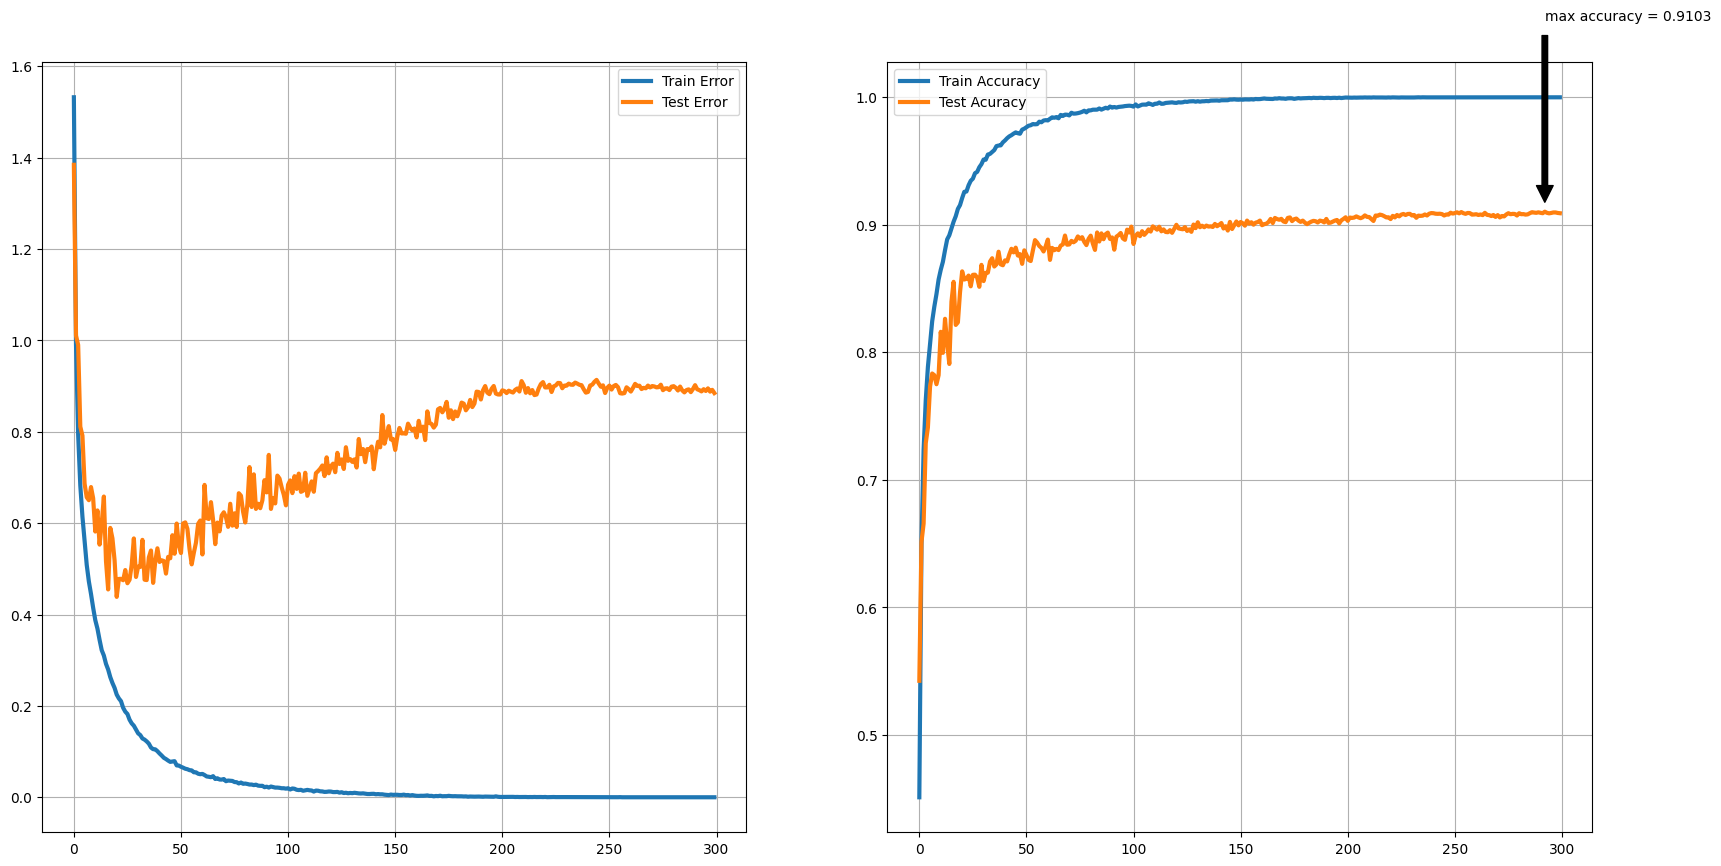

In [ ]:
# Create a figure object with two subplots, with a size of 20 by 10.
f, (fig1, fig2) = plt.subplots(1, 2, figsize=(20, 10))

# Set the number of data points in the training data to n.
n = len(train_loss)

# Plot the training loss and testing loss against the number of epochs on the first subplot.
fig1.plot(range(n), train_loss, '-', linewidth='3', label='Train Error')
fig1.plot(range(n), test_loss, '-', linewidth='3', label='Test Error')

# Plot the training accuracy and testing accuracy against the number of epochs on the second subplot.
fig2.plot(range(n), train_accuracy, '-', linewidth='3', label='Train Accuracy')
fig2.plot(range(n), test_accuracy, '-', linewidth='3', label='Test Acuracy')

# Annotate the maximum accuracy achieved with an arrow on the second subplot.
fig2.annotate('max accuracy = %s'%(ymax), xy=(xmax, ymax), xytext=(xmax, ymax+0.15), arrowprops=dict(facecolor='black', shrink=0.05))

# Turn on the grid lines for both subplots.
fig1.grid(True)
fig2.grid(True)

# Add legends to both subplots.
fig1.legend()
fig2.legend()

# Save the figure to a file named "trainTestCurve.png".
f.savefig("./trainTestCurve.png")


In [ ]:
torch.save(model.state_dict(), '/content/model1.pt')

Below we are just converting our pt model into onnx format to build the Resnet Architecture diagram

In [ ]:
pip install onnx


Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 13.5/13.5 MB 89.7 MB/s eta 0:00:00


In [ ]:
model = resnet_model()
model.load_state_dict(torch.load('/content/model1.pt'))
# set the model to inference mode
model.eval()

# Let's create a dummy input tensor  
dummy_input = torch.randn(4, 3, 32, 32)
# torch.onnx.export(model, dummy_input, "final_model.onnx")

# Export the model  
torch.onnx.export(model,         # model being run
      dummy_input,       # model input (or a tuple for multiple inputs)
      "final_model1_0pt1.onnx",       # where to save the model  
      export_params=True,  # store the trained parameter weights inside the model file
      opset_version=13,    # the ONNX version to export the model to
      do_constant_folding=True,  # whether to execute constant folding for optimization
      input_names = ['modelInput'],   # the model's input names
      output_names = ['modelOutput'],# the model's output names
)

torch.save(model.state_dict(), 'final_model1_0pt1.pt')




Model Config: 
-------------------------------------
N (# Layers)	: 4 
B (# Blocks)	: [3, 3, 2, 3] 
C (# Channels)	: [64, 128, 128, 256] 
F (Conv Kernel)	: [3, 3, 3, 3] 
K (Skip Kernel)	: [1, 1, 1, 1] 
P (Pool Kernel)	: 4
============= Diagnostic Run torch.onnx.export version 2.0.0+cu118 =============
verbose: False, log level: Level.ERROR
======================= 0 NONE 0 NOTE 0 WARNING 0 ERROR ========================



In [ ]:
from google.colab import files
files.download('final_model1_0pt1.onnx')


<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

In [ ]:
import urllib.request
from IPython.display import SVG, display

# URL of the SVG image we are downloading
url = "https://svgshare.com/i/s0w.svg"

# Download the SVG image
svg_data = urllib.request.urlopen(url).read()

# Display the SVG image in Colab
display(SVG(svg_data))
